In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
seed = 42
import dmeq
import jax.numpy as jnp
from jax import pmap, vmap, jit, random
from scipy.stats.qmc import LatinHypercube

In [2]:
key = random.PRNGKey(seed)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
n_samples = int(1e5)

bounds = pd.DataFrame.from_records([
    ('EIR', 0, 100),
    ('eta', 1/(40 * 365), 1/(20 * 365)),
    ('Q0', 0, 1),
    ('s2', 1, 3),
    ('rU', 1/1000, 1/30),
    ('cD', 0, 1),
    ('g_inf', 0.01, 10),
    ('cU', 0, 1),
    ('kb', 0.01, 10),
    ('ub', 1, 10),
    ('uc', 1, 10),
    ('ud', 1, 10),
    ('kc', .01, 10),
    ('b0', .01, .99),
    ('b1', .01, .99),
    ('IB0', 1, 100),
    ('IC0', 1, 100),
    ('tau', 1, 20),
    ('phi0', 0, 1),
    ('phi1', 0, 1),
    ('mu', 0, 1),
    ('f', 0, 1),
    ('fd0', 0, 1),
    ('ad0', 20 * 365, 40 * 365),
    ('gd', 1, 10)
], columns=['name', 'lower', 'upper'])

sampler = LatinHypercube(d=len(bounds), seed=42)

samples = sampler.random(n_samples)

samples = samples * (bounds.upper - bounds.lower).to_numpy() + bounds.lower.to_numpy()

In [4]:
jsamples = jnp.array(samples)
batched_samples = jnp.reshape(
    jsamples,
    (cpu_count, int(jsamples.shape[0] / cpu_count)) + jsamples.shape[1:]
)

In [5]:
param_keys = list(bounds['name'])
p = dmeq.default_parameters()

@jit
def run_eq(params):
    local_p = p.copy()
    for i in range(len(param_keys)):
        local_p[param_keys[i]] = params[i]
    return dmeq.solve(local_p, dtype=jnp.float64)

runner = pmap(vmap(run_eq, in_axes=0), in_axes=0)

results = runner(batched_samples)
results = jnp.reshape(results, (jsamples.shape[0], -1))

In [6]:
rand_index = random.permutation(key, n_samples, independent=True)
cut = int(n_samples * 0.8)
idx_train, idx_test = rand_index[:cut], rand_index[cut:] 

In [7]:
result_ranges = [
    (0, 100), # prev
    (100, 200), # inc
    (200, 300) # prop
]

result_stats = [
    (
        jnp.mean(results[idx_train,lower:upper], axis=None),
        jnp.std(results[idx_train,lower:upper], axis=None)
    )
    for lower, upper in result_ranges
]

standard_results = jnp.concatenate([
    (results[:,result_ranges[i][0]:result_ranges[i][1]] - result_stats[i][0]) / result_stats[i][1]
    for i in range(len(result_ranges))
], axis=1)

In [33]:
sample_mean, sample_std = jnp.mean(samples[idx_train], axis=0), jnp.std(samples[idx_train], axis=0)
standard_samples = (samples - sample_mean) / sample_std

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers

2023-01-18 16:53:49.143480: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [34]:
X_train = standard_samples[idx_train]
y_train = standard_results[idx_train]
X_test = standard_samples[idx_test]
y_test = standard_results[idx_test]

In [35]:
def create_model(
    optimiser='adam',
    n_hidden=3,
    units=288,
    dropout=.1,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal'
):
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],), dtype='float32'))
    # model.add(scaler)
    for i in range(n_hidden):
        model.add(layers.Dense(
            units,
            activation=hidden_activation,
            kernel_initializer=hidden_initialiser)
        )
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(y_train.shape[1], activation=output_activation, kernel_initializer=output_initialiser))
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [ ]:
model = create_model()
model.fit(tf.constant(X_train), tf.constant(y_train), batch_size=100, epochs=100)

In [13]:
y_hat = model.predict(tf.constant(X_test))

625/625 [==============================] - 1s 1ms/step


In [28]:
def inverse_standardise(x):
    return jnp.concatenate([
        x[:,result_ranges[i][0]:result_ranges[i][1]] * result_stats[i][1] + result_stats[i][0]
        for i in range(len(result_ranges))
    ], axis=1)

In [29]:
def prev_2_10(y):
    return tf.reduce_sum(y[:,2:10], axis=1) / tf.reduce_sum(y[:,202:210], axis=1)

In [30]:
def inc_0_5(y):
    return tf.reduce_sum(y[:,100:105], axis=1) / tf.reduce_sum(y[:,200:205], axis=1)

Text(0, 0.5, 'true')

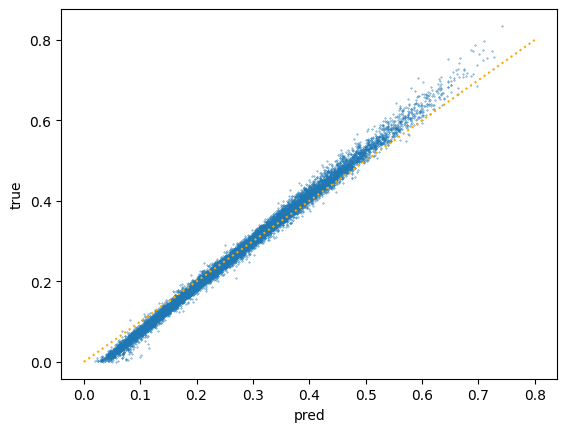

In [31]:
plt.scatter(prev_2_10(inverse_standardise(y_hat)), prev_2_10(inverse_standardise(y_test)), s=0.1)
plt.plot(np.linspace(0, 0.8), np.linspace(0, 0.8), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

Text(0, 0.5, 'true')

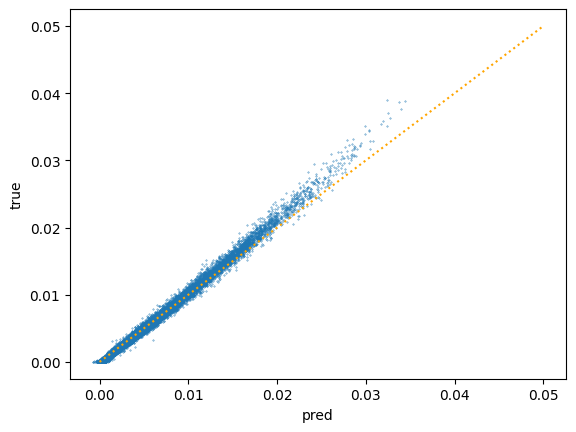

In [32]:
plt.scatter(inc_0_5(inverse_standardise(y_hat)), inc_0_5(inverse_standardise(y_test)), s=0.1)
plt.plot(np.linspace(0, 0.05), np.linspace(0, 0.05), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [23]:
y_train

Array([[2.72176944, 3.03938014, 2.70606991, ..., 0.19855711, 0.19323181,
        7.74602802],
       [3.11811373, 4.11417367, 3.32655966, ..., 0.04002274, 0.03774838,
        0.9924361 ],
       [2.42152183, 2.81072845, 2.45634104, ..., 0.15103015, 0.1462617 ,
        5.11068955],
       ...,
       [5.89590528, 6.76057206, 5.98096797, ..., 0.03362417, 0.0315662 ,
        0.82954197],
       [3.52478014, 4.59128724, 4.34757319, ..., 0.0795151 , 0.07612015,
        2.17462063],
       [3.80895238, 4.31661346, 3.71377844, ..., 0.11551371, 0.11133909,
        3.51683004]], dtype=float64)

In [24]:
model.predict(tf.constant(X_train))

2500/2500 [==============================] - 4s 2ms/step


array([[2.797764  , 3.2323132 , 2.817651  , ..., 0.10378533, 0.10005315,
        2.7707784 ],
       [2.797764  , 3.2323132 , 2.817651  , ..., 0.10378533, 0.10005315,
        2.7707784 ],
       [2.797764  , 3.2323132 , 2.817651  , ..., 0.10378533, 0.10005315,
        2.7707784 ],
       ...,
       [2.797764  , 3.2323132 , 2.817651  , ..., 0.10378533, 0.10005315,
        2.7707784 ],
       [2.797764  , 3.2323132 , 2.817651  , ..., 0.10378533, 0.10005315,
        2.7707784 ],
       [2.797764  , 3.2323132 , 2.817651  , ..., 0.10378533, 0.10005315,
        2.7707784 ]], dtype=float32)

In [57]:
import keras_tuner as kt

In [64]:
def bulid_hypermodel(hp):
    return create_model(
        n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, step=1),
        units = hp.Int("units", min_value=32, max_value=1024, step=32),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.01),
        loss = hp.Choice("loss", ['mse', 'log_cosh']),
        #hidden_activation = hp.Choice("hidden_activation", ['relu', 'elu']),
        #output_activation = hp.Choice("output_activation", ['linear', 'softmax'])
    )

In [65]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="eq",
)

In [66]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}


In [67]:
from sklearn.model_selection import train_test_split

X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [68]:
tuner.search(
    tf.constant(X_hyp_train),
    tf.constant(y_hyp_train),
    validation_data=(tf.constant(X_hyp_val), tf.constant(y_hyp_val)),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 69 Complete [00h 00m 18s]
val_mse: 0.405358225107193

Best val_mse So Far: 0.4034186899662018
Total elapsed time: 00h 22m 16s

Search: Running Trial #70

Value             |Best Value So Far |Hyperparameter
4                 |5                 |n_hidden
224               |480               |units
0.09              |0.17              |dropout
log_cosh          |log_cosh          |loss
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
  89/2000 [>.............................] - ETA: 7s - loss: 128.3964 - mse: 199129.0312

KeyboardInterrupt: 

625/625 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

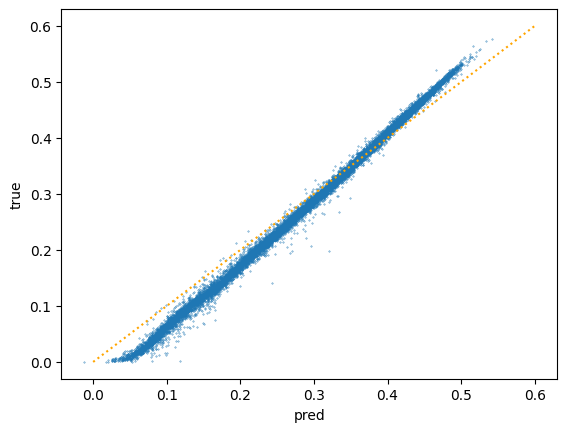

In [23]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.7), np.linspace(0, 0.7), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [21]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 5
units: 288
dropout: 0.0
loss: log_cosh
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 3.450794247328304e-05
Trial summary
Hyperparameters:
n_hidden: 4
units: 256
dropout: 0.01
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 3.650778307928704e-05
Trial summary
Hyperparameters:
n_hidden: 3
units: 64
dropout: 0.01
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 3.801256025326438e-05
Trial summary
Hyperparameters:
n_hidden: 4
units: 64
dropout: 0.01
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tun

In [12]:
model.save('models/eq')

INFO:tensorflow:Assets written to: models/eq/assets
